# Mean-Reversion

In this section, we describe trading around specific scheduled events. 

## Macroeconomic events

In [1]:
#hide
from IPython.display import display, Image

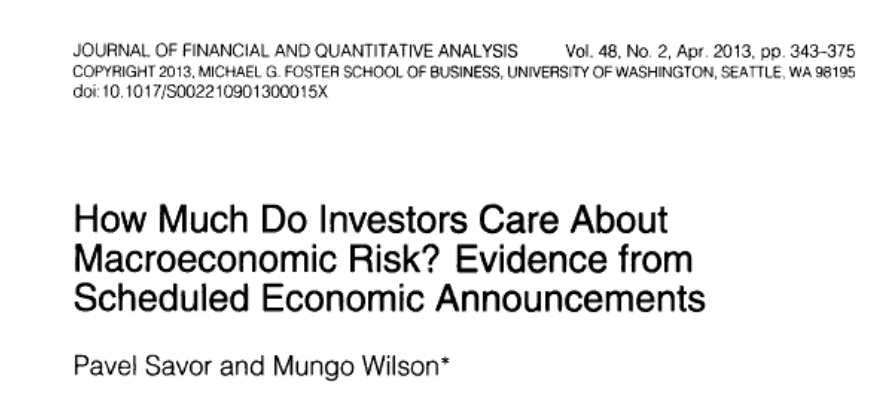

In [2]:
#hide 
display(Image('images/savor_title.png',width=500))

Three statements in Savor and Wilson (2013): 

- U.S. stock market returns are significantly higher on days when important macroeconomic news is scheduled to be announced.
- Inversely, the returns on T-Bills is significantly lower on these days.
- The announcement surprises do not seem to predict the returns. 

These facts are consistent with risk-averse investors demanding higher return for holding event risk. 

Data: 

- 157 prescheduled CPI announcements from Jan. 1958 to Jan. 1971 and 467 for the PPI from Feb. 1971 to Dec. 2009. 
- 621 employment announcements from Jan. 1958 to Dec. 2009. 
-  FOMC interest rate announcements start in Jan. 1978 and end in Dec. 2009. 

Any unscheduled announcements are excluded, leaving us with 279 FOMC observations.

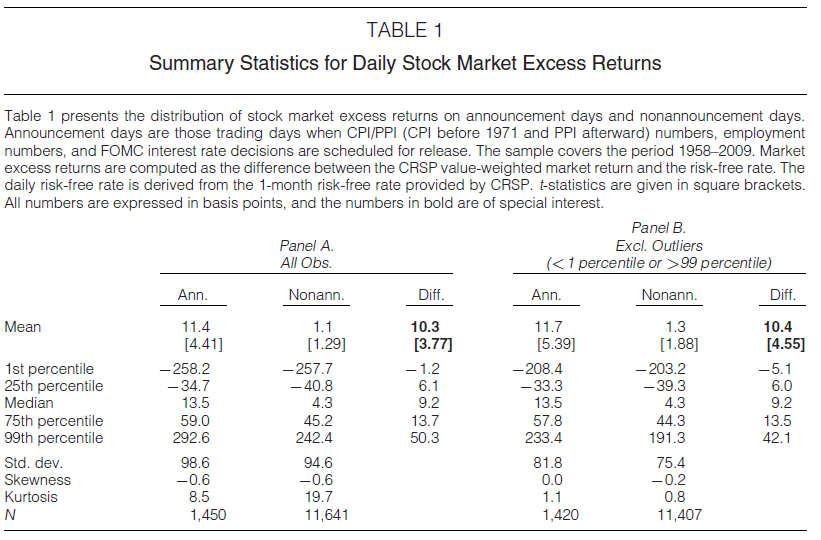

In [3]:
#hide 
display(Image('images/l6_savor_1.PNG',width=500))

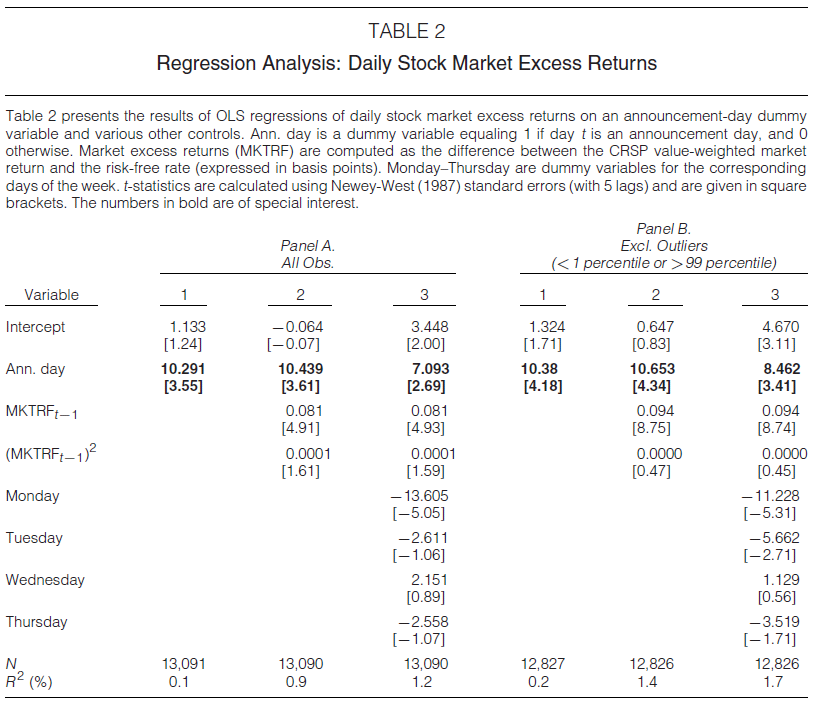

In [4]:
#hide
display(Image('images/l6_savor_2.PNG', width=500))

The return (resp. standard deviation) is 11.4bps (resp. 98.6 bps) on announcement days and 1.1bps (resp. 94.6 bps) on non-announcement days, so that the annualized Sharpe ratios very different, 1.8 and .18 respectively. The next two figures show similar statements (with inverse sign) for the risk-free asset (= T-Bills) -- impacted by precautionary saving demand.

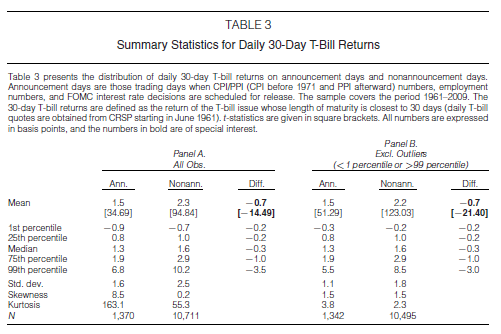

In [5]:
#hide 
display(Image('images/savorWilsonTable3.PNG',width=500))

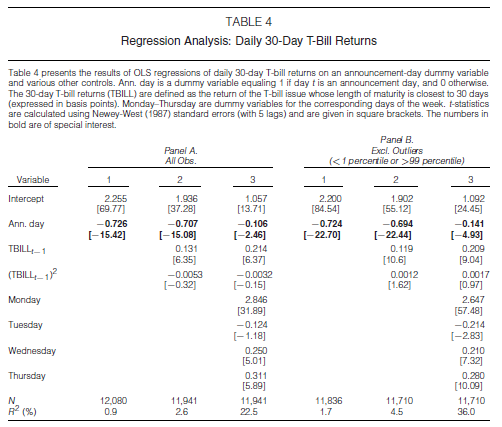

In [6]:
#hide
display(Image('images/savorWilsonTable4.PNG', width=500))

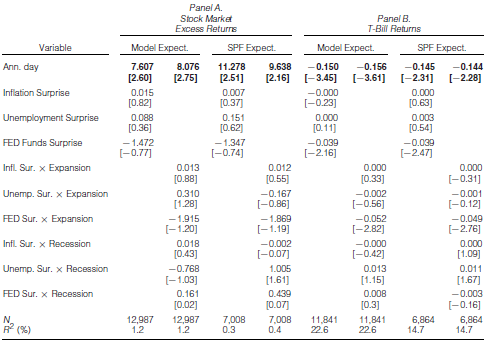

In [7]:
#hide
display(Image('images/savorWilsonTable5.PNG', width=500))

Other events from the follow-up paper: Savor and Wilson (2014): ``Asset pricing: a Tale of Two Days," 

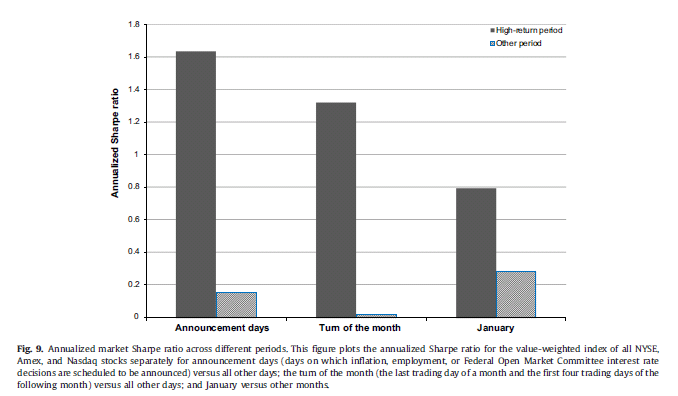

In [8]:
#hide 
#sidebyside 
Image('images/l6_savor_3.PNG',width=500)

## FOMC dates

In [9]:
#hide 
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from IPython.display import Image
from matplotlib import pyplot as plt

In [10]:
from ml4pmt.dataset import load_fomc_statements
from ml4pmt.text import show_text
from ml4pmt.plot import line, bar

In [11]:
statements = load_fomc_statements(force_reload=False)

INFO:ml4pmt.dataset:loading from external source


  0%|          | 0/203 [00:00<?, ?it/s]

INFO:ml4pmt.dataset:saving cache file /home/schamponn/python/sypy/2022-machine-learning-portfolio-management-and-trading/nbs/data/fomc_statements.parquet


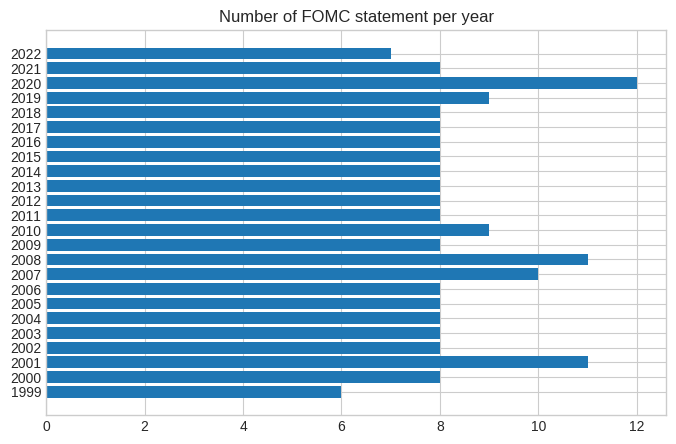

In [12]:
bar(statements.groupby(lambda x: x.year)['text'].count(), sort=False,
    horizontal=True, title='Number of FOMC statement per year')

## Returns on statement days

In [13]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import BDay
from ml4pmt.dataset import load_kf_returns
ret = load_kf_returns(filename="F-F_Research_Data_Factors_daily")['Daily']

INFO:ml4pmt.dataset:loading from external source
INFO:ml4pmt.dataset:saving in cache directory /home/schamponn/python/sypy/2022-machine-learning-portfolio-management-and-trading/nbs/data/F-F_Research_Data_Factors_daily


In [14]:
ret_norm = ret.div(ret.ewm(252).std())[statements.sort_index().index[0]:].asfreq('B')

Some FOMC meetings on Sundays or when the markets are closed: 

- '2008-01-21': Luther King Jr Day 
- '2010-05-09': Sunday 
- '2020-03-15': (note the release time!!!)

In [15]:
special_days = ['2008-01-22', '2010-05-09', '2020-03-15']
idx0 = pd.to_datetime(pd.Index(special_days))
idx = statements.index.difference(idx0).union(idx0 + BDay(1))

In [16]:
ret_fomc = pd.concat({'fomc': ret_norm.loc[ret_norm.index.intersection(idx)],
                      'not fomc': ret_norm.loc[ret_norm.index.difference(idx)]}, axis=1)

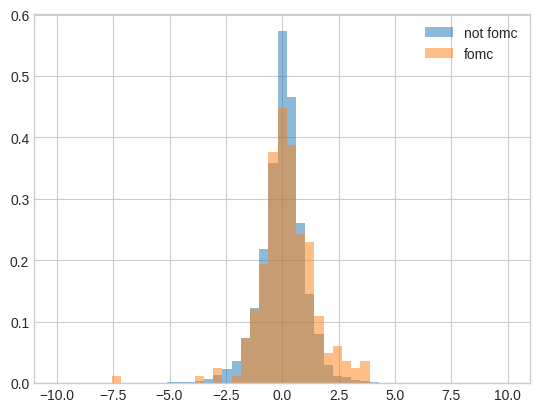

In [17]:
bins = np.linspace(-10, 10, 50)
plt.hist(ret_fomc['not fomc']['Mkt-RF'].dropna(), bins, density=True, alpha=0.5, label='not fomc')
plt.hist(ret_fomc['fomc']['Mkt-RF'].dropna(), bins, density=True, alpha=0.5, label='fomc')
plt.legend(loc='upper right')
plt.show()

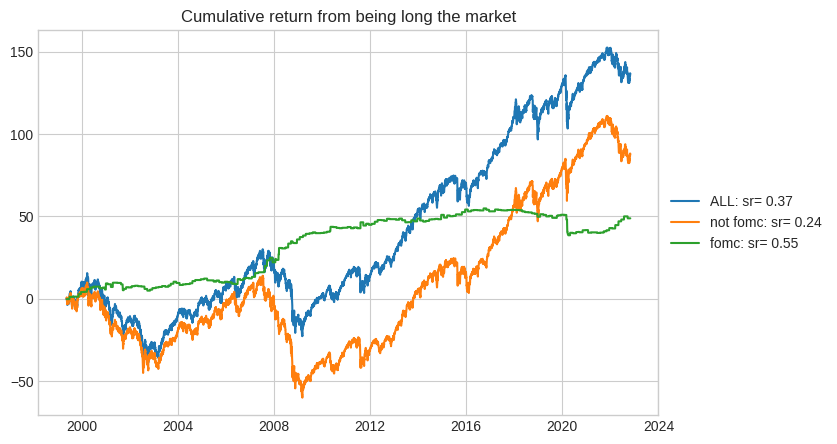

In [18]:
line(ret_fomc.xs('Mkt-RF', axis=1, level=1).fillna(0).assign(ALL = lambda x: x.sum(axis=1))['1996':],
cumsum=True, title='Cumulative return from being long the market')

In [19]:
ret_fomc.std().unstack().round(2)

,Mkt-RF,SMB,HML,RF
fomc,1.26,1.06,1.26,2.69
not fomc,0.99,1.00,1.01,2.70


In [20]:
from ml4pmt.metrics import sharpe_ratio

In [21]:
ret_fomc.pipe(sharpe_ratio).unstack().round(2)

,Mkt-RF,SMB,HML,RF
fomc,3.08,1.89,-0.31,12.78
not fomc,0.25,0.17,0.01,12.34


In [22]:
ret_fomc.clip(lower=-3, upper=3).pipe(sharpe_ratio).unstack().round(2)

,Mkt-RF,SMB,HML,RF
fomc,3.60,1.86,-0.46,17.93
not fomc,0.32,0.20,-0.07,17.32


In [23]:
ret_fomc.drop(pd.to_datetime('2020-03-16')).asfreq('B').pipe(sharpe_ratio).unstack().round(2)

,Mkt-RF,SMB,HML,RF
fomc,3.91,1.93,-0.24,12.73
not fomc,0.25,0.17,0.01,12.34
